In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

In [6]:
train = np.loadtxt("/content/drive/MyDrive/statlog+landsat+satellite/sat.trn")
test = np.loadtxt("/content/drive/MyDrive/statlog+landsat+satellite/sat.tst")

In [7]:
data = np.vstack((train,test))
np.random.shuffle(data)

X = data[:, :-1]
y = data[:, -1].astype(int)

In [5]:
!head -n 5 /content/drive/MyDrive/statlog+landsat+satellite/sat.trn


92 115 120 94 84 102 106 79 84 102 102 83 101 126 133 103 92 112 118 85 84 103 104 81 102 126 134 104 88 121 128 100 84 107 113 87 3
84 102 106 79 84 102 102 83 80 102 102 79 92 112 118 85 84 103 104 81 84 99 104 78 88 121 128 100 84 107 113 87 84 99 104 79 3
84 102 102 83 80 102 102 79 84 94 102 79 84 103 104 81 84 99 104 78 84 99 104 81 84 107 113 87 84 99 104 79 84 99 104 79 3
80 102 102 79 84 94 102 79 80 94 98 76 84 99 104 78 84 99 104 81 76 99 104 81 84 99 104 79 84 99 104 79 84 103 104 79 3
84 94 102 79 80 94 98 76 80 102 102 79 84 99 104 81 76 99 104 81 76 99 108 85 84 99 104 79 84 103 104 79 79 107 109 87 3


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
import pandas as pd

df = pd.DataFrame(X)
df['label'] = y

# Check missing
print(df.isnull().sum())

# Drop duplicates if any
df.drop_duplicates(inplace=True)

# Reassign
X = df.drop('label', axis=1).values
y = df['label'].values


0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
label    0
dtype: int64


In [10]:
import numpy as np
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(1): np.int64(1533), np.int64(2): np.int64(703), np.int64(3): np.int64(1358), np.int64(4): np.int64(626), np.int64(5): np.int64(707), np.int64(7): np.int64(1508)}


In [11]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import uniform
import warnings
warnings.filterwarnings('ignore')

In [12]:
param_dist = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': uniform(0.1, 10),
    'gamma': uniform(0.001, 0.1)
}

In [13]:
results = []
convergence_logs = []


In [14]:
for i in range(10):
    print(f"🔁 Processing Sample {i+1}/10")

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=i, stratify=y)

    # Initialize and tune SVM with class weights
    clf = RandomizedSearchCV(
        SVC(class_weight='balanced'),
        param_distributions=param_dist,
        n_iter=100,
        cv=3,
        scoring='accuracy',
        random_state=42,
        return_train_score=False
    )

    clf.fit(X_train, y_train)

    best_model = clf.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Sample": f"S{i+1}",
        "Accuracy": acc,
        "Best Kernel": clf.best_params_['kernel'],
        "Best C": round(clf.best_params_['C'], 4),
        "Best Gamma": round(clf.best_params_['gamma'], 4)
    })

    convergence_logs.append(clf.cv_results_['mean_test_score'])


🔁 Processing Sample 1/10
🔁 Processing Sample 2/10
🔁 Processing Sample 3/10
🔁 Processing Sample 4/10
🔁 Processing Sample 5/10
🔁 Processing Sample 6/10
🔁 Processing Sample 7/10
🔁 Processing Sample 8/10
🔁 Processing Sample 9/10
🔁 Processing Sample 10/10


In [15]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
print("\n✅ Accuracy Table:")
print(results_df)


✅ Accuracy Table:
  Sample  Accuracy Best Kernel  Best C  Best Gamma
0     S4  0.917659         rbf  4.9674      0.0916
1     S7  0.914034         rbf  8.1744      0.0906
2     S9  0.913516         rbf  8.1744      0.0906
3     S6  0.913516         rbf  4.9674      0.0916
4    S10  0.912998         rbf  4.9674      0.0916
5     S1  0.912481         rbf  8.1744      0.0906
6     S2  0.909891         rbf  4.9674      0.0916
7     S5  0.907820         rbf  8.1744      0.0906
8     S8  0.907820         rbf  8.1744      0.0906
9     S3  0.897980         rbf  5.5145      0.0706


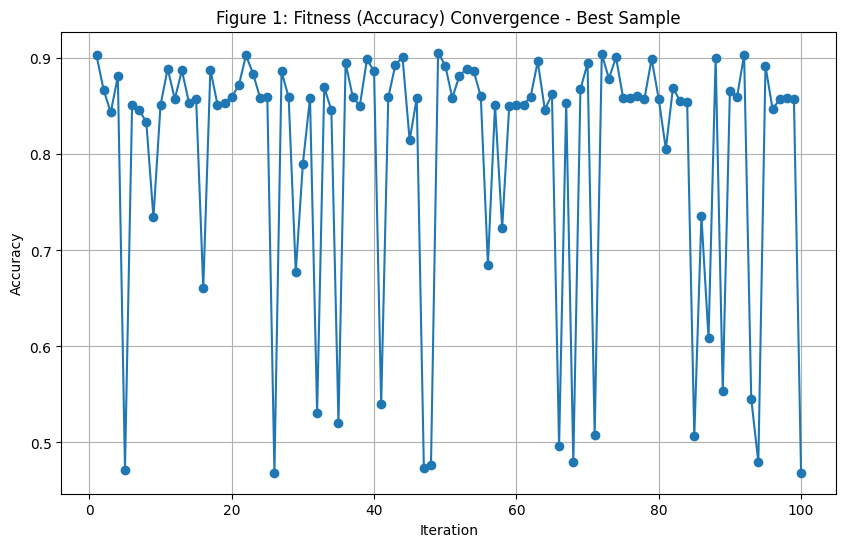

In [16]:
best_sample_idx = results_df.index[0]
best_convergence = convergence_logs[best_sample_idx]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_convergence) + 1), best_convergence, marker='o')
plt.title("Figure 1: Fitness (Accuracy) Convergence - Best Sample")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()